In [16]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/final_data.csv')
df.head(3)

,category,headline_length,short_description_length,content,content_processed,content_len,processed_len
0,NEWS,76,154,Over 4 Million Americans Roll Up Sleeves For O...,over million americans roll sleeves omicron ta...,230,167
1,NEWS,89,159,"American Airlines Flyer Charged, Banned For Li...",american airlines flyer charged banned life af...,248,189
2,ENTERTAINMENT,69,64,23 Of The Funniest Tweets About Cats And Dogs ...,funniest tweets cats dogs week sept dog not un...,133,71


In [17]:

def create_w2v(embedding_dim, words, window, epochs, sg):
    '''
    creating word2vec or skipgram.
    '''
    #Creating Word2Vec
    w2v_model = gensim.models.Word2Vec(words , vector_size = embedding_dim , window = window , min_count = 1, epochs = epochs, sg = sg)
    print(f"- {'Word2Vec' if(sg==0) else 'Skipgram'} Created")
    print(f'- Vocabulary count: {len(w2v_model.wv)}')
    print(f'''- Similar words for word "great:\n"{w2v_model.wv.most_similar('great')}''')
    
    return w2v_model
    

def get_sentence_embedding(sent, model, flag):
    '''
    create embeddings by calculating mean of vectors of words in each review (preprocessed_text)
    '''
    list_vectors = []
    for word in sent:
        if(flag):
            #indicates fasttext
            vector = model.get_word_vector(word)
        else:
            vector = model.wv[word]
        list_vectors.append(vector)
    mean_vector = np.array(list_vectors).mean(axis=0)
    return mean_vector


# Creating "embeddings" column
def get_embedding_cols(df, embedding_dim, model, flag):
    '''
    returns df with embedded columns. flag indicates if its fasttext
    '''
    #df['embeddings'] = df['preprocessed_text'].apply(lambda x: get_sentence_embedding(x.split(), model))
    df['embeddings'] = df['content_processed'].apply(lambda x: get_sentence_embedding(x.split(), model, flag))
    

    #creating a column for each vector in embedding - 100 columns
    cols = [f'e_{i}' for i in range(1, embedding_dim + 1)]
    df[cols] = pd.DataFrame(df['embeddings'].tolist(), index= df.index)
    print('- Embeddings are created.')
    return df


In [18]:
#writing the text column to build embeddings
df.to_csv('data/text_label.txt', columns = ['content_processed'], header = None, index = False)


In [19]:
import fasttext

model = fasttext.train_unsupervised('data/text_label.txt', dim = 100)

print(f'FASTTEXT {model.dim} VECTOR EMBEDDING DIMENSIONS:')
print(f'=========================================')

ft_df_100 = get_embedding_cols(df, 100, model, True)

#writing to a new file
ft_df_100.to_csv('data/fasttext_100.csv', index = False)

print('- Fasttext embeddings Created')
print(f'- Vocabulary count: {len(model.words)}')
print(f'''- Similar words for word "great:\n"{model.get_nearest_neighbors('great', k=10)}''')

model.save_model('models/fasttext_model.bin')


Read 3M words
Number of words:  33490
Number of labels: 0
Progress: 100.0% words/sec/thread:   73754 lr:  0.000000 avg.loss:  2.183504 ETA:   0h 0m 0s


FASTTEXT 100 VECTOR EMBEDDING DIMENSIONS:


/var/folders/t5/tflj5hjs197_vv37fw2sdhdr0000gn/T/ipykernel_95827/2472963586.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cols] = pd.DataFrame(df['embeddings'].tolist(), index= df.index)
/var/folders/t5/tflj5hjs197_vv37fw2sdhdr0000gn/T/ipykernel_95827/2472963586.py:41: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[cols] = pd.DataFrame(df['embeddings'].tolist(), index= df.index)
/var/folders/t5/tflj5hjs197_vv37fw2sdhdr0000gn/T/ipykernel_95827/2472963586.py:41: PerformanceWarning: DataFrame is highly fragmented.  This

- Embeddings are created.
- Fasttext embeddings Created
- Vocabulary count: 33490
- Similar words for word "great:
"[(0.7081536650657654, 'greats'), (0.6797245740890503, 'good'), (0.6773821115493774, 'greatest'), (0.6725165247917175, 'greatist'), (0.6712645888328552, 'lovewith'), (0.6639158129692078, 'amazing'), (0.6582716107368469, 'best'), (0.6498251557350159, 'timeif'), (0.6458053588867188, 'loveif'), (0.6420291662216187, 'americathere')]


## Modelling

In [21]:
df1 = ft_df_100[ft_df_100['category'].isin(['POLITICS', 'WELLNESS', 'ENTERTAINMENT'])]

from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

# Fit and transform the column_to_encode
df1['encoded_category'] = label_encoder.fit_transform(df1['category'])


/var/folders/t5/tflj5hjs197_vv37fw2sdhdr0000gn/T/ipykernel_95827/2509157625.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df1['encoded_category'] = label_encoder.fit_transform(df1['category'])
/var/folders/t5/tflj5hjs197_vv37fw2sdhdr0000gn/T/ipykernel_95827/2509157625.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['encoded_category'] = label_encoder.fit_transform(df1['category'])


In [22]:
X = df1.drop(['encoded_category','category', 'content', 'content_processed', 'headline_length', 'short_description_length', 'content_len', 'processed_len', 'embeddings'], axis = 1)
y = df1['encoded_category']


In [25]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import classification_report

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify = y)

# Initializing the XGBoost classifier
xgb_classifier = XGBClassifier(max_depth = 9, n_estimators = 1000, random_state = 42)

# Training the classifier
xgb_classifier.fit(X_train, y_train)

# Making predictions on the testing set
y_pred = xgb_classifier.predict(X_test)

# Evaluating the classifier
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86      2182
           1       0.90      0.93      0.92      3231
           2       0.93      0.93      0.93      2318

    accuracy                           0.91      7731
   macro avg       0.91      0.90      0.90      7731
weighted avg       0.90      0.91      0.90      7731



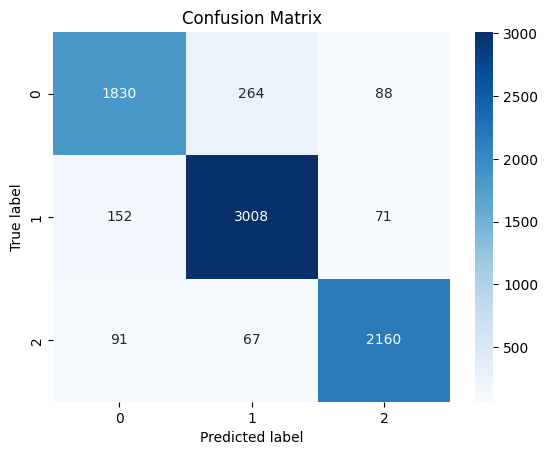

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', 
            xticklabels= np.unique(y_pred), 
            yticklabels= np.unique(y_test))

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()